# KerasによるCIFAR-10画像分類チュートリアル

---
---
---

# <font color="red">最終課題に向けたヒント</font>

## 質問と回答
- Conv2D(畳み込み)レイヤーを増やすと精度が上がるのはなぜ？<br>直感的な説明をすると　特徴を抽出、抽出した特徴の特徴を抽出、という風に、より抽象的な情報を得られるようになるから。機械の表現力が上がる。
- modelにあるpadding='same'というオプションはなに？<br>Conv2D(畳み込み)層を適用しても、出力データが小さくならないようにする。入力データの大きさを保った出力が出るようになる。
- modelの学習時に途中でエラー吐かれた。<br>学習中にエラーが吐かれる場合、jupyterのrestart the kernelのボタンを押して最初から動かしてみると吉？（変数の値変更やキャッシュの関係？）
- tutorial中の説明が全然わからん。<br>ごめんなさい、私の力不足です……。詳しく聞きたい人はTwitterの@minemichi宛に質問お願いします。
- 誤差逆伝播とは？<br>Twitterの@minemichi宛に(ry

## 精度を向上させるためのヒント
- 学習時のepochを増やすと……？
- 学習に使用するデータセットの量を増やしてみると……？
- optimizerをSGDからもっと優秀なものに変更してみると……？
- Conv2Dレイヤーを増やしてみると……？
- Conv2Dレイヤーの引数である次元数を増やしてみると……？<br>Conv2Dレイヤーの次元数は出力されるデータの枚数(ch)。多ければより多くの特徴を加味できる。2の累乗で指定するのが一般的(2^6=64など)。
- BatchNormalization()レイヤーを使用すると……？<br>使用する時はConv2DレイヤーとActivationレイヤーを分ける必要がある(https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras)。

---
---
---

## 概要
- もっとディープラーニングしよう
- CIFAR-10というカラー画像のデータセットに対して、画像分類を行うニューラルネットワークを構築していく
- データセットには32*32pixelのカラー画像とその答え(ラベル)が入っている

## 実行環境の確認

In [1]:
## development environment
# keras=2.2.0
# tensorflow=1.8.0
# dask=0.18.1
import keras
import tensorflow as tf
import dask

import warnings
warnings.filterwarnings('ignore')

print("keras={}".format(keras.__version__))
print("tensorflow={}".format(tf.__version__))
print("dask={}".format(dask.__version__))

Using TensorFlow backend.


keras=2.2.2
tensorflow=1.9.0
dask=1.0.0


## モジュールのインポート

In [2]:
from keras.models import Sequential
from keras.layers import Dense

## CIFAR-10データの読み込み
今回の学習に必要となるデータセットを読み込みます。  
kerasにはいくつかのサンプルデータセットをダウンロードしてくれるスクリプトが入っており、モジュールを通すことで簡単にダウンロードと読み込みを行ってくれます。

In [3]:
# CIFAR-10データのインポート
from keras.datasets import cifar10

In [4]:
#  Xは画像データ，yは画像データのラベル(0から9)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## CIFAR-10データの可視化

In [5]:
import numpy as np
# 可視化用ライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
# ラベル名を用意
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

In [7]:
# 各ラベルごとに画像を10枚格納
img_list = []
for for_1 in range(10):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0], 10)
    img_list.append(X_test[choice_idx])

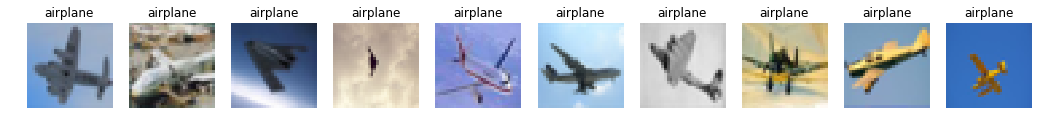

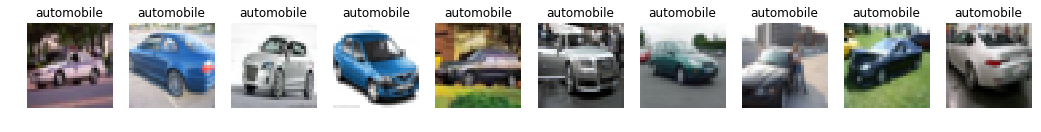

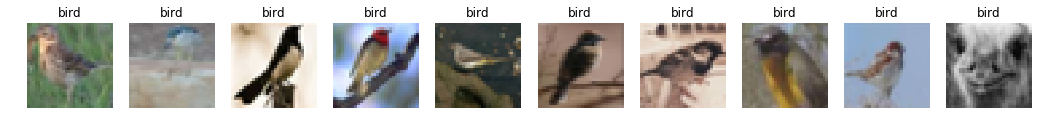

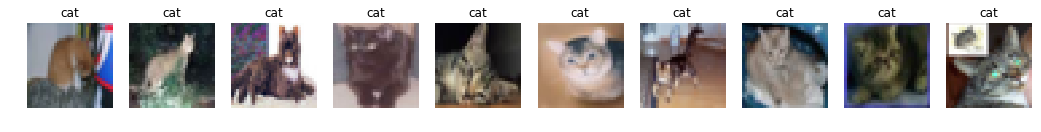

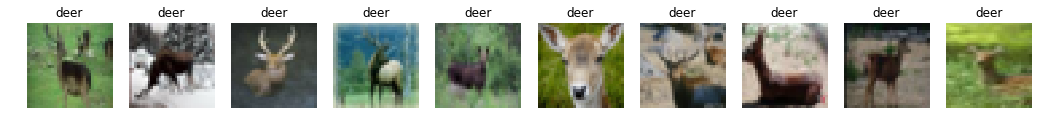

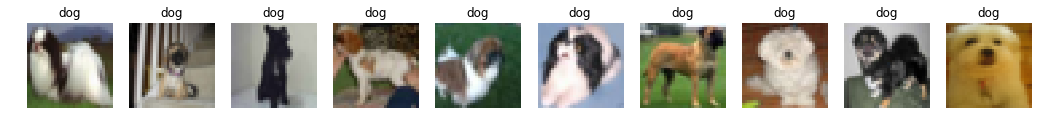

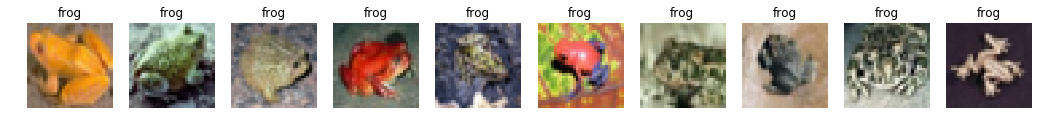

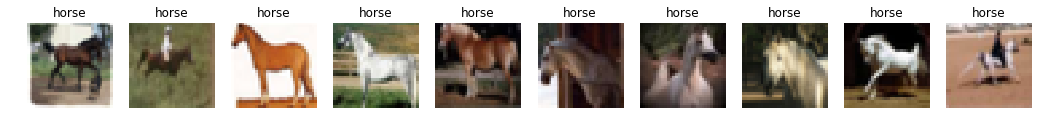

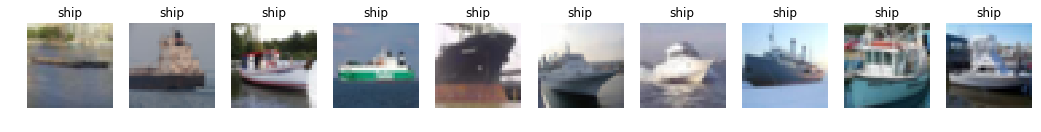

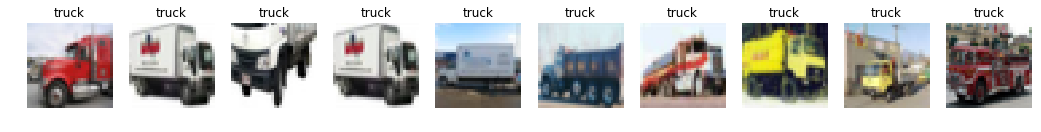

In [8]:
# データの可視化
for for_1 in range(10):
    fig, ax = plt.subplots(1, 10, figsize=(18, 8))
    for for_2 in range(10):
        ax[for_2].imshow(img_list[for_1][for_2].reshape(32, 32, 3)) #for_2の値+nでn番目以降のテストデータを出力する．
        ax[for_2].set_title(cifar10_labels[for_1])
        ax[for_2].axis('off')

## CIFAR-10データの前処理

- 入力する画像の次元数を決定し、ここでは縦32ピクセル，横32ピクセルの画像を扱うことにしています。
- MNISTデータは白黒でしたが、今回扱うCIFAR-10データはカラー画像なので、<br>pixelのチャンネル数を3に設定します。(赤、緑、青の計3色分の情報が必要)

In [9]:
img_rows, img_cols = 32,32
img_channels = 3

#### X_train について

- 画像はチャンネルごとに0から255までの数字を使って濃淡で表現されているので，ここでは値を大きくしないために255で割ってあげて，濃淡表現を0から1の間で表現している．
- なので型もintではなくfloatにする必要がある

In [10]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

#### Y_train について

- 学習用の画像の分類数は0から9までの10種類でありそれらは数値として表現されています。
- 今回作成する分類モデルでは各ラベルに対する正解である確率を求めるため、正解ラベルを数値からリストに変換しています。

In [11]:
nb_classes = 10 # 正解のパターン数

In [12]:
from keras.utils import np_utils
# クラスベクトルをバイナリクラスの行列に変換する
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [13]:
# クラスベクトル(ここでは一枚目の正解値は6)
y_train[0]

array([6], dtype=uint8)

In [14]:
# バイナリクラスの行列(10個ある正解パターンの中の6番目(0から数えて))
# 上も下もどちらも正解値は6を示している．
Y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [15]:
# backendの違いによる次元数の入力型の調整(おまじない)
from keras import backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

## モデルの構築

In [16]:
from keras.layers import Dropout,Flatten,Conv2D,MaxPooling2D

In [19]:
model = Sequential()
"""
model.add()の中にConv2DやMaxPooling2Dをいれてモデルを作ってみよう

サンプルで使用している関数一覧
---
# データの一次元配列化
    model.add(Flatten()) # 全結合層につなげる直前に使おう
# 全結合層
    model.add(Dense(次元数, activation=活性化関数)) 
# 畳み込み層
    model.add(Conv2D(次元数, kernel_size=フィルターのサイズ,activation=活性化関数,input_shape=input_shape))
# プーリング層
    model.add(MaxPooling2D(pool_size=プーリングするサイズ))
# ドロップアウト
model.add(Dropout(0から1までの数値)) # 学習するパーセプトロンのうち使用しない割合を設定
---

その他、調べてみて便利な関数があればぜひ追加してみよう
"""

# この下のmodelを改造して自作のネットワークを作ってみよう
model.add(Conv2D(20, kernel_size=(3, 3), padding='same', activation="relu", input_shape=input_shape))
model.add(Conv2D(20, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(20, kernel_size=(3, 3),  padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 20)        560       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 20)        3620      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 20)        3620      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 50)        9050      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 50)        22550     
__________

## モデルの最適化関数や誤差関数を設定

In [23]:
from keras.optimizers import SGD, Adadelta, Adam, RMSprop # 最適化手法

"""
モデルを評価する関数をmodel.compile()で定義しよう

実際にmodel.compileの中にはこのようにします

model.compile(loss=誤差関数,
             optimizer=最適化関数,
             metrics=['accuracy']
             )
             
誤差関数　モデルの精度の悪さを表す指標　誤差逆伝播時にパラメータの更新方向を決定する数値
・categorical_crossentropy

最適化関数(好きなものを選ぼう)　誤差逆伝播時にパラメータを更新する手法
・SGD
・Adadelta
・Adam
  Adamは最近主流になっている最適化関数。一般的にSGDよりも優秀(例外はある)。
・RMSprop

評価指標
・accuracy
"""

model.compile(loss="categorical_crossentropy", # 誤差(損失)関数
              optimizer="SGD", # 最適化関数
              metrics=["accuracy"] # 評価指標
             )

## モデルの保存とパラメータの保存

In [24]:
# JSON形式でモデルを保存
json_string = model.to_json()
#open('./keras_mlp.json', 'w').write(json_string)
open('./cifar10_cnn.json', 'w').write(json_string)

5476

In [25]:
#　初期ウエイトの保存
model.save_weights('./cifar10_cnn_init_weight.hdf5', overwrite=True)

## モデルの読み出しとパラメータの呼び出し
- 学習後、Jupyterを落としたあとでも、モデルを再読込するための準備
- 初回の学習時には無関係

In [26]:
# from keras.models import model_from_json, model_from_yaml

In [27]:
# JSON形式で保存されたモデルの呼び出し
# json_string = open('./cifar10_cnn.json', 'r').read()
# model = model_from_json(json_string)

In [28]:
# model.load_weights('./mnist_cnn_best_weight1.hdf5')

## 学習
+ tensorboard --logdir=/tmp/keras_cnn
+ http://0.0.0.0:6006

In [29]:
# TensorBoardで学習の進捗状況をみる
tb_cb = keras.callbacks.TensorBoard(log_dir='/tmp/keras_cnn', histogram_freq=1)

# バリデーションロスが下がれば、エポックごとにモデルを保存
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./cifar10_cnn_best_weight1.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='auto')

# バリデーションロスが５エポック連続で上がったら、ランを打ち切る
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5, 
                                      verbose=0, 
                                      mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [30]:
import time

In [31]:
print(X_train.shape)
print(X_train[:500].shape)

(50000, 32, 32, 3)
(500, 32, 32, 3)


In [32]:
# 学習を実行
# 学習途中の損失関数の値などはhistory.historyに保存される。
# CIFAR-10のようにカラー画像ともなると学習時間が多くなってしまう……
# 今回は学習を早く終わらせるために学習に使用するデータの数を[:1024]と少なくしている。
# 精度を重視するならX_train[:1024]をX_trainとし全てのデータを使用すべき。
# ここでエラーが吐かれる場合、jupyterのrestart the kernelのボタンを押して最初から動かしてみるなど。
history = model.fit(X_train[:1024], Y_train[:1024],
                    batch_size=512,  # 512個ランダムに得る
                    nb_epoch=5, # 試行回数
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=cbks)

Train on 1024 samples, validate on 10000 samples
Epoch 1/5
1024/1024 [==============================] - 39s 38ms/step - loss: 2.3096 - acc: 0.1191 - val_loss: 2.3049 - val_acc: 0.1002

Epoch 00001: val_loss improved from inf to 2.30495, saving model to ./cifar10_cnn_best_weight1.hdf5
Epoch 2/5
1024/1024 [==============================] - 32s 31ms/step - loss: 2.3107 - acc: 0.1074 - val_loss: 2.3041 - val_acc: 0.1015

Epoch 00002: val_loss improved from 2.30495 to 2.30408, saving model to ./cifar10_cnn_best_weight1.hdf5
Epoch 3/5
1024/1024 [==============================] - 34s 33ms/step - loss: 2.3096 - acc: 0.1211 - val_loss: 2.3034 - val_acc: 0.1034

Epoch 00003: val_loss improved from 2.30408 to 2.30339, saving model to ./cifar10_cnn_best_weight1.hdf5
Epoch 4/5
1024/1024 [==============================] - 33s 32ms/step - loss: 2.3070 - acc: 0.1016 - val_loss: 2.3029 - val_acc: 0.1067

Epoch 00004: val_loss improved from 2.30339 to 2.30288, saving model to ./cifar10_cnn_best_weight1.

## ベストパラメータの呼び出し

In [33]:
model.load_weights('./cifar10_cnn_best_weight1.hdf5')

## 学習結果の評価

In [34]:
# テストデータに対する評価値
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0]) # 損失関数の値
print('Test accuracy:', score[1]) # 精度(98%強)

Test score: 2.302568138504028
Test accuracy: 0.1084


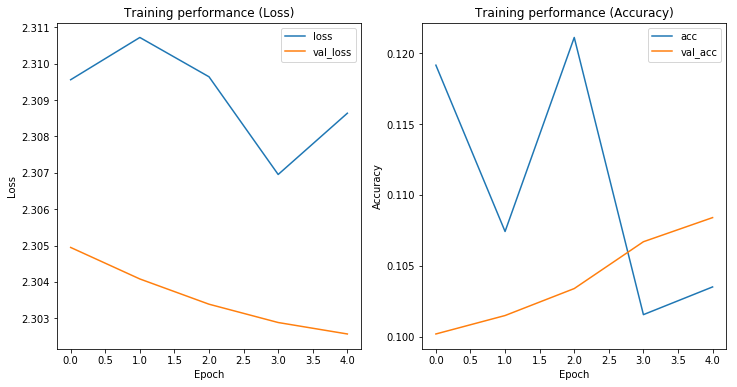

In [35]:
# 学習曲線
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

## 予測の可視化

In [36]:
# 予測値
# 各ラベルごとに画像を10枚格納
New_test = []
for for_1 in range(10):
    choice_idx = np.random.choice(np.where(y_test == for_1)[0])
    New_test.append(X_test[choice_idx])
New_test = np.array(New_test)
# 画像のラベルを推定する
Y_test_pred = model.predict(New_test)

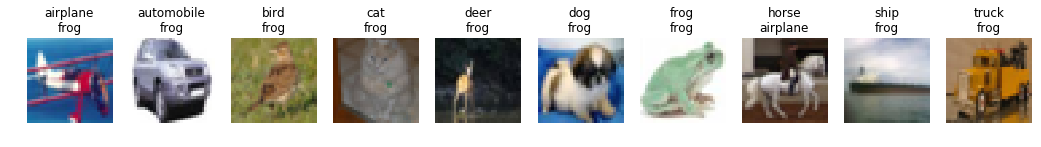

In [38]:
# データの可視化
# 上段は正しいラベル　下段は推測ラベル
fig, ax = plt.subplots(1, 10, figsize=(18, 8))
for for_1 in range(10):
    ax[for_1].imshow(New_test[for_1].reshape(32, 32, 3)) #for_2の値+nでn番目以降のテストデータを出力する．
    ax[for_1].set_title(cifar10_labels[for_1]+"\n"+cifar10_labels[np.argmax(Y_test_pred[for_1])])
    ax[for_1].axis('off')

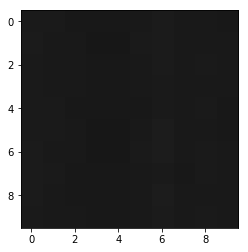

In [40]:
# 予測の可視化
# Y軸が渡した画像の数字　X軸がニューラルネットワークによる推定値
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を変えることで予測の場所を変更できる